In [29]:
import optuna
from optuna.samplers import TPESampler
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random
import os
from joblib import dump

# Fix random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

optuna.logging.set_verbosity(optuna.logging.WARNING)

HYPERPARAMETERS_SEARCH = False

# Pre-processing input data

In [30]:
# train_df and test_df are created in eda notebook
if not os.path.exists('csv/train_df.csv') or not os.path.exists('csv/test_df.csv'):
	print('Please run the eda notebook first')
	exit()
train_df = pd.read_csv('csv/train_df.csv')
test_df = pd.read_csv('csv/test_df.csv')
target = 'total_time_target'
features = test_df.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target','vendor_id_raw', 'arch'])

# Split data
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Normalize data
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

In [31]:
if not os.path.exists('../models/x_scaler.joblib') or not os.path.exists('../models/y_scaler.joblib'):
	dump(x_scaler, '../models/x_scaler.joblib')
	dump(y_scaler, '../models/y_scaler.joblib')

# Model: XGBoost

In [32]:
def inv_scaling(y, y_scaler):
    return y_scaler.inverse_transform(y.reshape(-1, 1))

# Hyperparameters Optimization

In [33]:
def objective(trial: optuna.Trial, X_train, y_train, X_test, y_test):
	dtrain = xgb.DMatrix(X_train, label=y_train)
	dtest = xgb.DMatrix(X_test, label=y_test)
	
	# Definimos los hiperparámetros a buscar (XGBoost)
	param = {
		"verbosity": 0,
		"device": "cuda",
		"objective": "reg:squarederror",
		"eval_metric": "rmse",
		"booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
		# L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
		"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
	}
	num_boost_round = trial.suggest_int("num_boost_round", 10, 1000, step=10)
    
	if param["booster"] in ["gbtree", "dart"]:
		# maximum depth of the tree, signifies complexity of the tree.
		param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
		# minimum child weight, larger the term more conservative the tree.
		param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
		param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
		# defines how selective algorithm is.
		param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
		param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

	if param["booster"] == "dart":
		param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
		param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
		param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
		param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

	# training
	evals_result = {}
	xgb.train(
		param, 
		dtrain,
		num_boost_round=num_boost_round,
		evals=[(dtrain, "train"), (dtest, "test")],
		evals_result=evals_result,
		verbose_eval=False,
		early_stopping_rounds=25
	)
	loss = evals_result['train']['rmse'][-1]
	val_loss = evals_result['test']['rmse'][-1]
	print(f"Trial: {trial.number} - RMSE Loss : {loss} - RMSE Val Loss: {val_loss}")
	return val_loss

n_trials = 100
study = None

In [34]:
if HYPERPARAMETERS_SEARCH:
	study = optuna.create_study(direction='minimize', sampler=sampler)
	study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=n_trials)

In [35]:
if study is not None:
	print(f'Number of trials: {len(study.trials)}')
	trial = study.best_trial
	print(f'Best trial: {trial.number}')
	print(f'Best params: {trial.params}')
	print(f'Best validation loss: {y_scaler.inverse_transform(np.reshape(trial.value, (-1,1))).item()}')

# Training

In [36]:
# hyperparameters
params = {
	"device": "cuda",
	"objective": "reg:squarederror",
	"eval_metric": "rmse",
}
if study is not None:
	num_boost_round = study.best_trial.params['num_boost_round']
	params.update(*study.best_trial.params)
	params.pop('num_boost_round')
else:
	num_boost_round = 10

In [37]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

evals_result = {}
model = xgb.train(
	params, 
	dtrain,
	num_boost_round=num_boost_round,
	evals=[(dtrain, "train"), (dtest, "test")],
	evals_result=evals_result,
	early_stopping_rounds=10
)

[0]	train-rmse:0.03569	test-rmse:0.01913
[1]	train-rmse:0.02529	test-rmse:0.01362
[2]	train-rmse:0.01800	test-rmse:0.00986
[3]	train-rmse:0.01289	test-rmse:0.00722
[4]	train-rmse:0.00934	test-rmse:0.00547
[5]	train-rmse:0.00683	test-rmse:0.00419
[6]	train-rmse:0.00509	test-rmse:0.00335
[7]	train-rmse:0.00392	test-rmse:0.00286
[8]	train-rmse:0.00312	test-rmse:0.00263
[9]	train-rmse:0.00256	test-rmse:0.00236


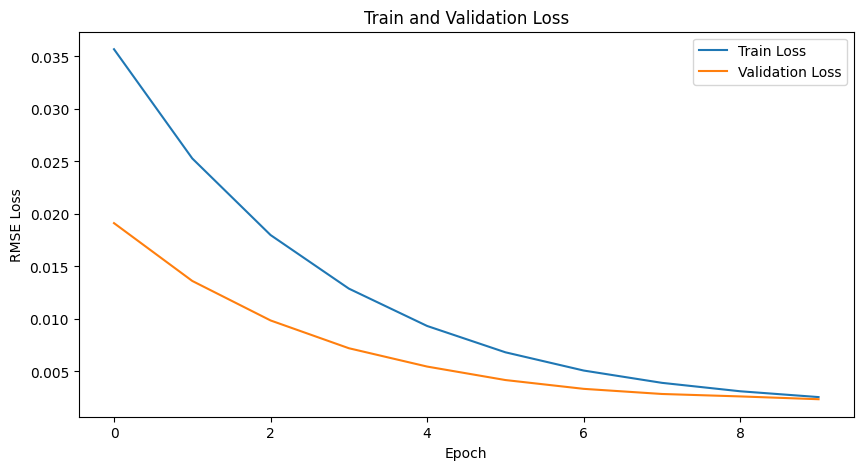

In [38]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['train']['rmse'], label='Train Loss')
plt.plot(evals_result['test']['rmse'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.legend()
plt.show()

In [39]:
# save model
model.save_model(f'../models/xgboost_model.json')

# Describe Validation

In [40]:
model = xgb.Booster()
model.load_model('../models/xgboost_model.json')

In [41]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}
	dtest = xgb.DMatrix(X)
	predictions = model.predict(dtest)
	predictions = inv_scaling(predictions, y_scaler)
	y_scaled = inv_scaling(y, y_scaler)
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [42]:
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = inv_scaling(y_test, y_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 16.036476135253906 | Std actual: 23.300222396850586
Mean actual: 16.002460942900594 | Std actual: 23.942981274873418
Mean Error: 1.340394671265225 | Std Error: 1.6413255705300906
Min instance
total_time                                                            10.93
total_cpu_usage                                                        0.99
max_ram_usage                                                     44.214844
brand_raw                          Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    32
l2_cache_size                                                          32.0
l3_cache_size                                                          22.0
l2_cache_line_size                                                      